# 背景介绍

假设某一通信运营商，要在业务中使用数据科学，想要部署ML模型。

通过结合用户行为数据和分类算法来创建用户流失模型，对当前用户进行流失预测。

# 定义ML目标

用户流失指的是用户不再使用企业提供的服务或迁移到竞争对手那里。对于任何企业而言，留存和吸引系用户都是企业运营核心。

该项目的业务目标就是分析用户相关数据，开发一个ML用户流失预测模型，识别出高流失风险的用户，并找出影响用户流失的主要指标，以辅助运营决策，制定降低用户流失率的策略。

## 业务目标

利用前三个月的特征数据预估第四个月的用户流失倾向。

## ML目标

* 探索用户流失前可能会表现出的异常行为：用户通常不会立即决定转向其他竞争对手，而是经过一定时间后才决定转向，这一点尤其适用于高价值用户。捕捉用户流失前的行为变化对特征的模型构建至关重要。
* 建立回归/分类模型预测用户流失：基于用户的历史行为数据构建用户流失预测模型

# 数据收集


## 数据获取

数据集包括4个csv文件：
* 用户流失数据
* 用户人口统计数据
* 互联网合约数据
* 元数据（数据字典）

## 加载数据

In [1]:
import pandas as pd

# 控制Pandas在notebook的显示,行列不会折叠
pd.options.display.max_columns = None
pd.options.display.max_rows = 10

* 加载流失数据

In [2]:
# 流失数据主表，包含主要信息
churn_df = pd.read_csv("./data/churn_data.csv")
print("数据维度信息: {}".format(churn_df.shape))
churn_df.head()

数据维度信息: (7043, 9)


,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


* 加载用户人口统计数据

In [3]:
# 用户人口统计数据
customer = pd.read_csv("./data/customer_data.csv")
print("数据维度信息：{}".format(customer.shape))
customer.head()

数据维度信息：(7043, 5)


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


* 加载互联网合约数据

In [4]:
# 互联网合约数据
contract = pd.read_csv("./data/internet_data.csv")
print("数据维度信息：{}".format(contract.shape))
contract.head()

数据维度信息：(7043, 9)


,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


* 加载元数据

In [5]:
# 数据字典
meta = pd.read_csv("./data/Telecom Churn Data Dictionary.csv")
meta.head()

,S.No.,VariableName,Meaning
0,1,CustomerID,The unique ID of each customer
1,2,Gender,The gender of a person
2,3,SeniorCitizen,Whether a customer can be classified as a seni...
3,4,Partner,If a customer is married/ in a live-in relatio...
4,5,Dependents,If a customer has dependents (children/ retire...


* 接下来需要将3个表合并成一个宽表，customerID作为索引

In [6]:
# 设置索引
for i in [churn_df, customer, contract]:
    i.set_index("customerID", inplace=True)

churn_df.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,
7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# 连接三个数据文件，一个接一个，以customerID作为索引
df = churn_df.join(customer).join(contract)

# 确保没有1：N的关系，即没有重复，再次打印数据维度
print("整合后的数据维度信息：{}".format(df.shape))
df.head()

整合后的数据维度信息：(7043, 20)


,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,0,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


# 数据预处理

## 缺失值处理

In [8]:
df.dtypes

tenure               int64
PhoneService        object
Contract            object
PaperlessBilling    object
PaymentMethod       object
                     ...  
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Length: 20, dtype: object

In [9]:
df.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [10]:
# 定义方法来统计缺失值
def check_stats(df):
    '''
    返回一个显示主要统计数据和附加指标的表格（数据框）
    '''
    # 把数据类型储存在一个独立的数据框架中
    df_info = pd.DataFrame(df.dtypes, columns=["dtypes"])
    
    # 计算缺失记录总和
    df_info = df_info.join((df.replace({'':None,' ':None}) if "('O')" in str(df.dtypes.values) else df).isna().sum().rename("isna"))
    
    # 在最后一步添加统计数据（仅对数值列进行计算）
    return df_info.T.append(df.describe(),sort=False)

check_stats(df).T.query("isna != 0")

,dtypes,isna,count,mean,std,min,25%,50%,75%,max
TotalCharges,object,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# # 对缺失进行处理
# import numpy as np
# df.TotalCharges = df.TotalCharges.replace(to_repalce=np.nan,value=df.TotalCharges.median())

# # TypeError: could not convert string to float:

类型不对，需要进行转换

In [12]:
telco2 = df.copy()
# we are converting all the values in the TotalCharges data to float, 
# However, for blank strings we are going to impute nan ... errors= 'coerce'
telco2['TotalCharges'] = pd.to_numeric(telco2['TotalCharges'],errors= 'coerce')

In [13]:
import numpy as np
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors= 'coerce')
df.TotalCharges = df.TotalCharges.replace(to_replace=np.nan, value= df.TotalCharges.median())
check_stats(df).T.query("isna != 0")

,dtypes,isna,count,mean,std,min,25%,50%,75%,max


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.000,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.350,89.85,118.75
TotalCharges,7043.0,2281.916928,2265.270398,18.80,402.225,1397.475,3786.60,8684.80
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.000,0.000,0.00,1.00


## 离群值检测

离群值是原理分布或者平均值的观测值，但他们不一定代表异常行为。

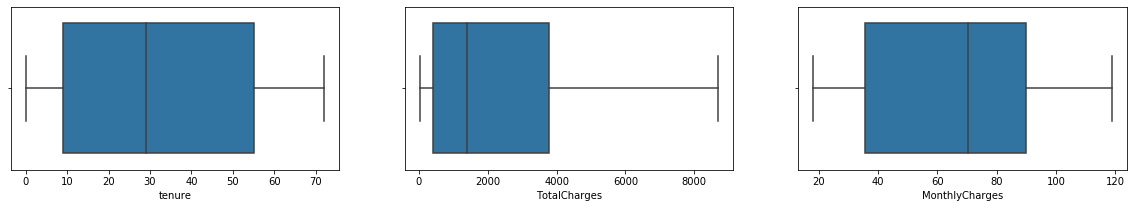

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 对数值型变量进行离群值检测
plt.figure(figsize=(20,3))

plt.subplot(1,3,1)
sns.boxplot(df.tenure)

plt.subplot(1,3,2)
sns.boxplot(df.TotalCharges)

plt.subplot(1,3,3)
sns.boxplot(df.MonthlyCharges)

plt.show()

发现总消费额（TotalCharges）分布是有偏的。

In [19]:
# 关注5%-95%的总消费额数据
perc5 = round(np.percentile(df['TotalCharges'],5),2)
perc95 = round(np.percentile(df['TotalCharges'],95),2)
print("重点关注总费用介于{}与{}之间的用户".format(perc5,perc95))

重点关注总费用介于49.65与6921.02之间的用户


In [21]:
# 过滤数据集
df = df.loc[(df['TotalCharges'] <= perc95) & (df['TotalCharges'] >= perc5)]
df.shape

(6338, 20)

# 数据探索

从业务角度分析可能导致用户流失的因素：
* 服务方面：当前服务不能满足用户的需求或竞争对手拥有更适合用户的服务。
* 用户方面：用户的需求发生了变化，比如，之前的主要需求是打电话，现在换为智能手机，需求更偏向于使用流量。

## 目标变量

首先对目标变量进行简要的分析，初步了解当前样本的用户流失情况，比如查看流失用户占比。

Rectangle(xy=(0, -0.4), width=4655, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=1683, height=0.8, angle=0)


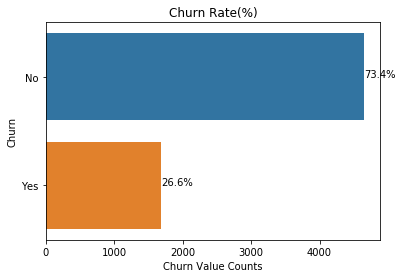

In [32]:
def bar_plot(df,column):
    ax = sns.countplot(y=column, data=df)
    plt.title('Churn Rate(%)')
    plt.xlabel('Churn Value Counts')
    
    total = len(df[column])
    for p in ax.patches:
        print(p)
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage,(x,y))
    plt.show()
bar_plot(df,'Churn')

我们发现流失用户占比26.6%，发现目标存在不平衡情况。

## 服务分析

对当前样本中正常用户和流失用户接受网络服务的情况进行简要分析。

[Text(0, 0, 'DSL'),
 Text(0, 0, 'Fiber optic'),
 Text(0, 0, 'Not receiving internet service')]

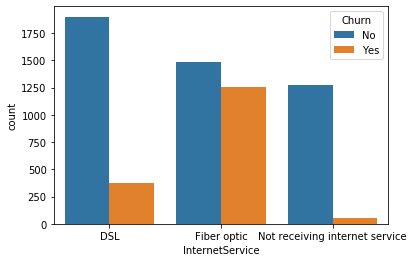

In [34]:
ax = sns.countplot(x='InternetService',hue='Churn',data=df,order=['DSL','Fiber optic','No'])
ax.set_xticklabels(['DSL','Fiber optic','Not receiving internet service'])

接受网络服务的的用户流失率明显高于未接受网络服务的，尤其是使用了光纤（Fiber optic）的流失率达到了40%，所以这个服务可能存在一定的问题。

对于网络服务，可以进一步探讨是否有其他附加服务会影响用户的流失率。比如，使用网络服务的用户对网络安全、网络备份、设备保护、技术支持等增值业务为付费情况：

[Text(0, 0.5, 'Num of churns'), Text(0.5, 0, 'Additional service')]

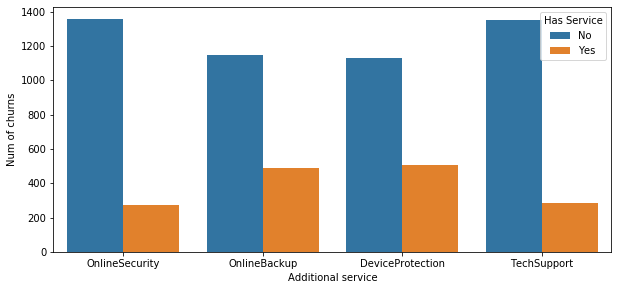

In [47]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport"]
plt.figure(figsize=(10,4.5))
df_new  = df.copy()

# 筛选出使用网络服务的并且是流失用户的数据
df_service = df_new[(df_new.InternetService != "No") & (df_new.Churn == "Yes")]

# pd.melt 将多列合并，也就是把cols的值编程variable的值，value就是源数据的Yes或No
df_service = pd.melt(df_service[cols]).rename({'value':'Has Service'},axis=1)

ax = sns.countplot(data=df_service, x='variable',hue='Has Service',hue_order=['No','Yes'])
ax.set(xlabel='Additional service',ylabel='Num of churns')

## 用户行为分析

# 特征工程